In [2]:
import glob
from timeit import default_timer as timer

import numpy as np
import torch
import clip
import hydra
import omegaconf
from PIL import Image
from torch import nn
import torchvision.transforms as T
import scipy.special

import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path

In [3]:
def convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(
        n_px=224,
        norm_mean=(0.48145466, 0.4578275, 0.40821073),
        norm_std=(0.26862954, 0.26130258, 0.27577711)):
    return T.Compose([
        T.RandomResizedCrop(
            size=n_px,
            scale=(0.7, 1.0),
            ratio=(0.75, 1.33),
            interpolation=T.InterpolationMode.BICUBIC,
        ),
        T.RandomVerticalFlip(p=0.5),
        T.RandomHorizontalFlip(p=0.3),
        convert_image_to_rgb,
        T.RandomApply(
            nn.ModuleList(
                [
                    T.ColorJitter(
                        brightness=0.2,
                        contrast=0.2,
                        saturation=0.1,
                        hue=0.0,
                    )
                ]
            ),
            p=1.0,
        ),
        T.ToTensor(),
        T.Normalize(norm_mean, norm_std),
    ])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# CONSTANTS
MODEL = "ViT-L-14"
DATASET = "ISIC_2018"
ADDITIONAL_COMMENTS = "CLASS_LABELS_PROMPTS"

In [6]:
# 1. Load Model
model_name = "zt0n2xd0"

print("[INFO] Loading model...")
cfg_model = omegaconf.OmegaConf.load("../configs/model/contrastive.yaml")
cfg_model.net.model_name_or_path = "ViT-L/14"
cfg_model.net.device = device

model = hydra.utils.instantiate(cfg_model)
model.to(device)
model.eval()

model_path_dir = {
    "zt0n2xd0": "/home/cristianopatricio/Downloads/weight.pt",
}

# Load model with saving weights
model_path = model_path_dir[model_name]
loaded = torch.load(model_path, map_location=device)
model.load_state_dict(loaded)
print('[INFO] Model loaded successfully!')

[INFO] Loading model...
[INFO] Model loaded successfully!


In [7]:
CLASS_LABELS_PROMPTS = {
    "BKL": ["This is dermatoscopy of pigmented benign keratosis", 'This is dermoscopy of pigmented benign keratosis'],
    "NV": ["This is dermatoscopy of nevus", 'This is dermoscopy of nevus'],
    "DF": ['This is dermatoscopy of dermatofibroma', 'This is dermoscopy of dermatofibroma'],
    "MEL": ['This is dermatoscopy of melanoma', 'This is dermoscopy of melanoma'],
    "VASC": ['This is dermatoscopy of vascular lesion', 'This is dermoscopy of vascular lesion'],
    "BCC": ['This is dermatoscopy of basal cell carcinoma', 'This is dermoscopy of basal cell carcinoma'],
    "AKIEC": ['This is dermatoscopy of actinic keratosis', 'This is dermoscopy of actinic keratosis']
}

In [8]:
REFERENCE_CONCEPT_PROMPTS = ["This is dermatoscopy", "This is dermoscopy"]

In [14]:
# Extract text features for each concept and save it to a numpy array
for disease_label in CLASS_LABELS_PROMPTS.keys():
    preprocess = _transform()
    batch = {
        "text": clip.tokenize(CLASS_LABELS_PROMPTS[disease_label]).to(device)
    }

    with torch.no_grad():
        text_features = model.model_step_with_text(batch)["text_features"]
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    np.save(f"text_embeddings/class_label_embeddings_{disease_label}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [15]:
# Extract text features for each concept and save it to a numpy array
preprocess = _transform()
batch = {
    "text": clip.tokenize(REFERENCE_CONCEPT_PROMPTS).to(device)
}

with torch.no_grad():
    text_features = model.model_step_with_text(batch)["text_features"]

text_features /= text_features.norm(dim=-1, keepdim=True)

np.save(f"text_embeddings/reference_prompts_embeddings_ISIC_2018.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [9]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):

    #print(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [10]:
def get_concept_score(image_features_norm,
                      prompt_target_embedding_norm,
                      prompt_ref_embedding_norm):

    #print(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)
    temp=0.02

    sim_cos_concept = image_features_norm.float() @ prompt_target_embedding_norm.T.float()
    sim_cos_ref = image_features_norm.float() @ prompt_ref_embedding_norm.T.float() 

    return (np.exp(sim_cos_concept.numpy() / temp) / (np.exp(sim_cos_concept.numpy() / temp) + np.exp(sim_cos_ref.numpy() / temp))).mean()

In [11]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_MONET_{MODEL}_Segmented_Norm_New.npy", allow_pickle=True).item()
reference_embeddings = torch.from_numpy(np.load(f"text_embeddings/reference_prompts_embeddings_ISIC_2018.npy")).unsqueeze(0)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)
    #print(f"IMG shape: {img_feats.shape}")

    similarity_scores = []
    for disease_label in CLASS_LABELS_PROMPTS.keys():
        text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}.npy")).unsqueeze(0)
        #print(f"TEXT shape: {text_feats.shape}")

        #similarity = get_similarity_score(img_feats, text_feats)
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=True)
        sim_2 = get_concept_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats[0],
                                                prompt_ref_embedding_norm=reference_embeddings[0])

        #print(similarity[0])
        #print(sim_2)

        similarity_scores.append(similarity[0])
        #similarity_scores.append(sim_2)

    # Calculate prediction given weights of melanoma
    results[im] = similarity_scores

[INFO] DATASET: ISIC_2018


In [12]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "ISIC_2018":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/image_classes_ISIC_2018.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_test.csv")
    test_images = test_images_df["images"].tolist()

"""
y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(np.max(results[im]))

        print(y_true_val)
        print(y_pred_probs_val)

    break

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
"""

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(np.argmax(results[im]))
        y_pred_probs.append(results[im])
        
target_names=['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

n_classes = len(target_names)
for i, c in enumerate(target_names):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = sum(sum(conf_matrix)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {c}: Sensitivity = {tpr:.3f}, Specificity = {tnr:.3f}, BACC = {((tpr + tnr) / 2):.3f}")

              precision    recall  f1-score   support

         BKL       0.21      0.72      0.32       217
          NV       0.80      0.01      0.02       908
          DF       0.06      0.02      0.03        44
         MEL       0.29      0.32      0.30       171
        VASC       0.05      0.66      0.10        35
         BCC       0.35      0.44      0.39        93
       AKIEC       0.00      0.00      0.00        43

    accuracy                           0.19      1511
   macro avg       0.25      0.31      0.17      1511
weighted avg       0.57      0.19      0.12      1511

[[157   1   2  26  14  17   0]
 [436   8  11  80 354  19   0]
 [ 27   0   1   4   6   6   0]
 [ 87   1   0  54  13  16   0]
 [  1   0   3   2  23   6   0]
 [ 25   0   0  16  11  41   0]
 [ 24   0   0   3   5  11   0]]
Class BKL: Sensitivity = 0.724, Specificity = 0.536, BACC = 0.630
Class NV: Sensitivity = 0.009, Specificity = 0.997, BACC = 0.503
Class DF: Sensitivity = 0.023, Specificity = 0.989, BA

/home/cristianopatricio/anaconda3/envs/MONET/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristianopatricio/anaconda3/envs/MONET/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cristianopatricio/anaconda3/envs/MONET/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [13]:
from sklearn.preprocessing import label_binarize

test_labels = label_binarize(y_true,
                        classes=[0, 1, 2, 3, 4, 5, 6])

In [14]:
prob_test_vec = np.array(y_pred_probs)
 
n_classes = 7
fpr = [0] * 7
tpr = [0] * 7
thresholds = [0] * 7
auc_score = [0] * 7

target_names=['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']

for i, c in enumerate(target_names):
    fpr[i], tpr[i], thresholds[i] = roc_curve(test_labels[:, i],
                                              prob_test_vec[:, i])

    if c == 'MEL':
        np.save("fpr_ISIC_2018_monet.npy", fpr[i])
        np.save("tpr_ISIC_2018_monet.npy", tpr[i])
        
    auc_score[i] = auc(fpr[i], tpr[i])
    print(f"AUC {c}: {auc(fpr[i], tpr[i])}")

print(f"Mean AUC: {np.mean(auc_score)}")

AUC BKL: 0.6376095983589627
AUC NV: 0.6890958204571853
AUC DF: 0.6148680052054285
AUC MEL: 0.7573077594483721
AUC VASC: 0.6738772744870306
AUC BCC: 0.8600406448579705
AUC AKIEC: 0.7879728787782776
Mean AUC: 0.7172531402276039


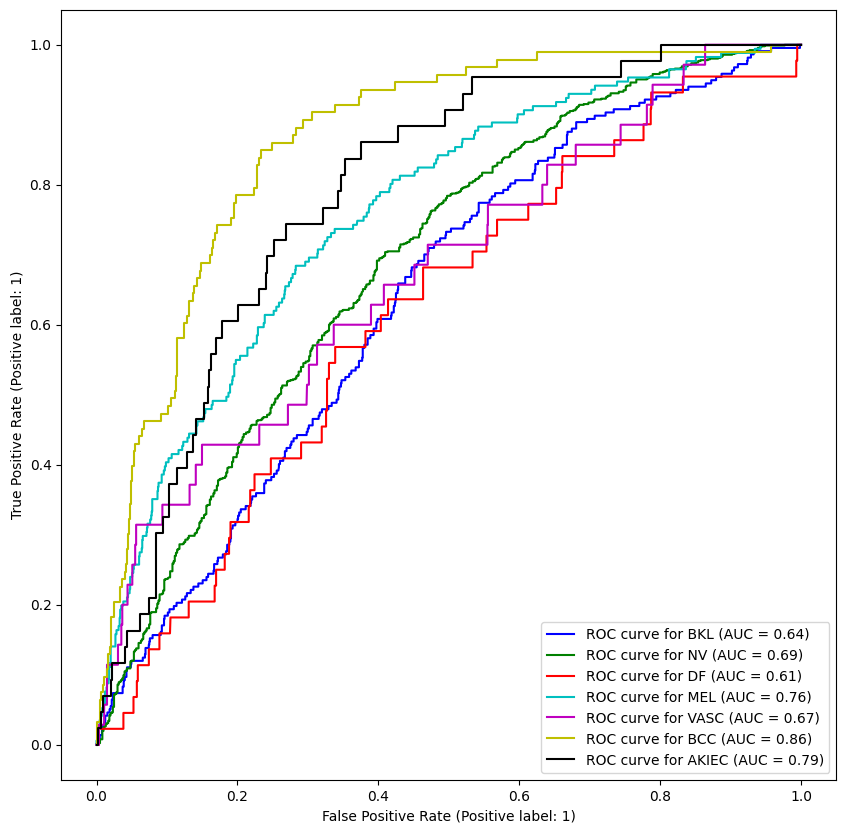

In [15]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
target_names = ['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        test_labels[:, class_id],
        prob_test_vec[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

In [2]:
import numpy as np

img_emb = np.random.randn(1, 768)
con_emb = np.random.randn(1, 768)
ref_emb = np.random.randn(2, 768)

con_emb /= np.linalg.norm(con_emb)
img_emb /= np.linalg.norm(img_emb)
ref_emb /= np.linalg.norm(ref_emb)

sim_cos_concept = np.dot(img_emb, img_emb.T)
print(sim_cos_concept)
sim_cos_ref = np.dot(img_emb, ref_emb.T)
print(sim_cos_ref)
temp = (1/np.exp(4.5944))

score = (np.exp(sim_cos_concept / temp) / (np.exp(sim_cos_concept / temp) + np.exp(sim_cos_ref / temp))).mean()
print(score)

[[1.]]
[[ 0.03853194 -0.01874331]]
1.0
